# Starbuck Capstone Challenge

## Project Overview

This notebook contains my capstone project for the data science nanodegree from Udacity. I'm using the data from Starbucks, that contains simulated mimics customer behavior. Once every few days, Starbucks sends offers to users of their app. These offers can be advertisements for a drink or an actual offer or a BOGO (buy one get one free). Not all users receive the same offer.

## Project Statement

The problem I'm trying to solve with this projects is find the right users for the right offer. While some user need an offer or a BOGO to buy something, others just need an advertisment or even not that. So the question is: Can I find a model that predicts how a customer will interact with an offer?

## Metrics 

The metrics I'll use to validate my model are accurracy and the f1-score. Because I'll have a multiclassifier ("Received", "Viewed", "Completed") I have to use the f1-score weighted. 


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

The data given from Starbucks is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

While this syntactic description of the data comes with the origin project, I'll look at the semantic details for every dataframe. 

#### Portfolie

There are 10 items with 6 features in. We have 4 bogos and 4 discounts, which means there are 8 different offers with an reward value and two items that are just informational. This dataset is very clean without any missing data.

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Profile

This dataset contains 17000 userdata with the features gender, age, when the became a member and their income. Each item also contains an id, which is unique, to identify the user. Let's have a quick view on the first items of that dataset.

In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


As we can see, there are some missing values in that dataframe and because of the size of the dataset I always starts to get some information about the dataset by calling info.
Unforunately there are 2175 items with missing values in gender and income and all of them are exactly 118 years old, which can be counted as missing too. 

In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


From this info we see the dataset has 2175 missing data points in gender and also in income. The first rows of the profile dataset tells us, that everytime we don't have a gender, we also missing the income and see an age of 118, which can be counted as missing too. I checked the rows where any data is missing and also the items where age is 118. They are the same rows and the only feature left for these items is when these users became a member.


In [5]:
profile[profile.isna().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [6]:
profile[profile['age']==118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


A look at the gender columns tells us, that we have more male than female users and a very few others, but the main information for now is, that this data is very clean, which is very good.

In [7]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Last point for the profile dataset is a quick view at the histogramm. We can see most of the users have an age of around 50 and we also see the peak at 118 (the "missing" datapoints), we also see with the time more and more users became members, which tells us that the app and the company seems to be successful at least in recruiting new customers. Most of the customers have an income between 50 and 75 thousand. 

 

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

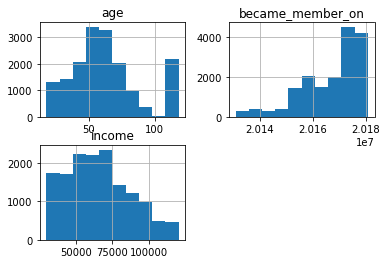

In [8]:
profile.hist()

Because there is no information about the currency I'll assume that this value is the same for all (I guess it's US dollar). There is also no information about the location people live in. There might be some differences in the income and maybe also in the price for Starbucks products?

#### Transcript

The third and last dataframe of the complete dataset for this project contains all interaction between users and an offer from Starbucks. Let's start with a quick view into the head of this dataset and because of the size also have a look at the info for the dataset.

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


The feeling of the view into the first rows can be confirmed with the info call. There are no missing data. Remember time shows the hours since this test dataset starts and it begins by hour 0.

Let's have a closer look at the time column and print some histogramms. First I want to see a histogram of only the offer received events.

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

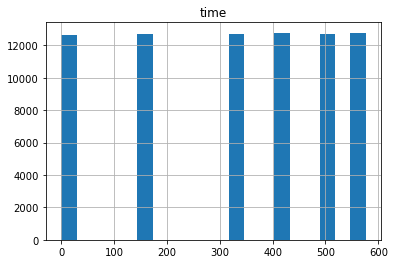

In [11]:
transcript[transcript['event']==('offer received')].hist(bins=20)

The histogramm shows the offers received events. So there seems to be 6 times in the data when Starbucks send an offer. Let's check that.

In [12]:
transcript[transcript['event']==('offer received')]['time'].value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

6 datapoints are confirmed. What about the "offer viewed" events? Can we see any relation to the "offer received" events? I would expect a peak when the customer receives the offer and than an decreasing number of events in time.

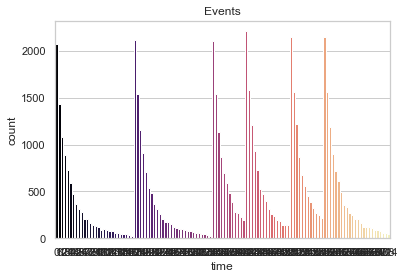

In [13]:
sns.set_theme(style="whitegrid")
sns.countplot(x = 'time', data = transcript[transcript['event']=='offer viewed'],  palette = 'magma')
plt.title('Events')
plt.show()

The above diagram shows exactly what I expected before. Lets also check the "offer completed" events. 

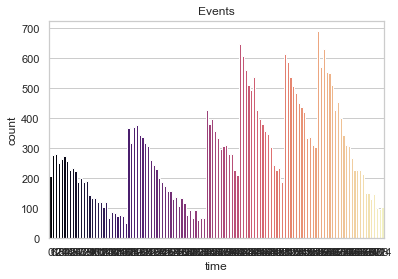

In [14]:
sns.set_theme(style="whitegrid")
sns.countplot(x = 'time', data = transcript[transcript['event']=='offer completed'],  palette = 'magma')
plt.title('Events')
plt.show()

Again, there is a peak in the "offer completed" datapoint when the offer was received and we also have that number of events decreasing like in the "offer viewed" data.

There is another question about how many events of each type does the dataset contain.

In [15]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

This is not really surprising. Nearly 20 thousand received offer are not even viewed by customers during the time of the given data and also more than 20 thousand viewed offers do not complete. 

Until now I had a closer look at the offer events, but there is another event in the transcript dataset called "transaction". These are real transactions from customers. I'll not use these "transaction" events in this project.

After checking all three datasets, I found very clean and usefull data. There are these 2175 users which are 13 % of the users where we have no gender, age or income, which I need to handle in the next part of this project, the preparation of the data.

## Data Preprocessing

The aim of this part is to create a dataset that contains user offer interactions. Let me explain this a bit more. We have 6 times Starbucks sends offers to some of their customers. My offers dataframe should contain for each customer id and offer id a time for receiving, viewing and completing.

Since the value column contains a dictionary I need a function that unwraps the offer id from that. This is waht the next function will do.

In [16]:
def unwrapDictionary(df, dictVar, col):
    '''
    Unwraps the value column from transcript dataframe into the given column
    
    INPUT:
    df - dataframe that contains the dictionary in column "value"
    dictVar - name of the variable in the dictionary 
    col - name of the column, where the value of the dictVar should be saved into
    '''
    df[col] = [v.get(dictVar) for v in df['value']]


Using this function I'll create three different dataframes for the events "offer received", "offer viewed" and "offer completed". The viewed and completed dataframe get also a new column with a specific time label, which I'll use in the next step.

In [17]:
offer_received = pd.DataFrame(transcript[transcript['event']=='offer received'])
unwrapDictionary(offer_received, 'offer id', 'offer_id')
offer_received.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [18]:
offer_viewed = pd.DataFrame(transcript[transcript['event']=='offer viewed'])
unwrapDictionary(offer_viewed, 'offer id', 'offer_id')
offer_viewed['time_viewed'] = offer_viewed['time']
offer_viewed.head()

,person,event,value,time,offer_id,time_viewed
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,ae264e3637204a6fb9bb56bc8210ddfd,0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,0


In [19]:
offer_completed = pd.DataFrame(transcript[transcript['event']=='offer completed'])
unwrapDictionary(offer_completed, 'offer_id', 'offer_id')
offer_completed['time_completed'] = offer_completed['time']

offer_completed.head()

,person,event,value,time,offer_id,time_completed
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In the next step I'll merge these three datasets on columns person and offer_id. The idea is to get for each offer for a customer a status whether this offer was just received, viewed or even completed.

First initialize an offer data frame with person, offer_id and time from offer_received dataframe. Next set status for all rows to "Received", because all of them are offer received events. Than merge the offer_viewed dataframe into the offers dataframe. Substract time_viewed and time to identify already viewed offers, which can be dropped. Also drop duplicates from offers dataset where person, offer_id and time is exactly the same offer.

Now, where time_viewed is not nan, we can change the status to "Viewed".

I'll do exactly the same with the offer_completed dataset. I'll merge it into the offers dataframe, calculated the duration for time_completed-time to identify the already completed rows, which can be dropped and again also drop duplicates.

This time we can change the status to "Completed", where time_completed is not nan.

In [20]:
def mergeOfferEvent(offers, offer_df, time_column, status):
    '''
        Merge given dataframes on person and offer_id. 
        Depending on the given timeColumn the already received offer will be found and 
        the status for that entry will be the new given status.
        
        INPUT:
        offers - the main dataframe to merge into
        offer_df - the dataframe to merge
        time_column - name of the time column in that dataset (must not be "time")
        status - the new status to set
    '''
    
    offers = offers.merge(offer_df[['person','offer_id',time_column]], on=['person','offer_id'], how='left')

    offers['duration'] = offers[time_column] - offers['time']
    offers = offers.drop(offers[offers['duration'] < 0].index)
    offers = offers.drop_duplicates(subset=['person','offer_id','time'])

    offers.loc[offers[time_column].notna(), 'status'] = status

    offers = offers.drop(columns=['duration', time_column])
    return offers

In [21]:
offers = pd.DataFrame(offer_received[['person', 'offer_id', 'time']])
offers['status'] = "Received"


offers = mergeOfferEvent(offers, offer_viewed, 'time_viewed', 'Viewed')
offers = mergeOfferEvent(offers, offer_completed, 'time_completed', 'Completed')

offers.head()

,person,offer_id,time,status
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,Completed
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,Viewed
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,Viewed
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,Viewed
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,Viewed


A quick view in the offer dataframe shows each offer for a customer has now a status. I also print out two persons with more than one offer received and their final status.

In [22]:
offers[offers['person']=='a03223e636434f42ac4c3df47e8bac43']


,person,offer_id,time,status
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,Viewed
28463,a03223e636434f42ac4c3df47e8bac43,3f207df678b143eea3cee63160fa8bed,336,Viewed
42624,a03223e636434f42ac4c3df47e8bac43,5a8bc65990b245e5a138643cd4eb9837,408,Received
56771,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,504,Viewed
70640,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,Viewed


In [23]:
offers[offers['person']=='2e87ba0fba1a4d1a8614af771f07a94d']


,person,offer_id,time,status
51,2e87ba0fba1a4d1a8614af771f07a94d,2298d6c36e964ae4a3e7e9706d1fb8c2,0,Completed
14311,2e87ba0fba1a4d1a8614af771f07a94d,2298d6c36e964ae4a3e7e9706d1fb8c2,168,Completed
28512,2e87ba0fba1a4d1a8614af771f07a94d,fafdcd668e3743c1bb461111dcafc2a4,336,Completed
42675,2e87ba0fba1a4d1a8614af771f07a94d,f19421c1d4aa40978ebb69ca19b0e20d,408,Completed
56814,2e87ba0fba1a4d1a8614af771f07a94d,5a8bc65990b245e5a138643cd4eb9837,504,Viewed


In [24]:
print('Number of offer_received', offer_received.shape[0])
print('Number of offers with status', offers.shape[0])
print('Number of missing offers', offer_received.shape[0]-offers.shape[0])


Number of offer_received 76277
Number of offers with status 74044
Number of missing offers 2233


We are missing 2233 offers. Whats happen with them? Well these are the last offers that are just received by customers that have at least another offer which was at least viewed **before** the last offer was received. Since these are offers without any interaction from the customer, I can ignore them.

In the next step I'll merge the profile dataframe into this offers dataframe in order to replace the person ids with there values, like gender, age, become_member_on and income.

In [25]:
offers = offers.merge(profile, left_on='person', right_on='id', how='left')

In [26]:
offers.head()

,person,offer_id,time,status,gender,age,id,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,Completed,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,Viewed,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,Viewed,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,Viewed,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,Viewed,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In the final step of this data preprocessing I'll rearrange the columns, drop person id columns and also drop the rows with missing values, since these are exactly the persons with missing data identified earlier.



In [27]:
offers = offers[['offer_id','time','gender','age','became_member_on','income','status']]
offers = offers.dropna()

offers = pd.get_dummies(offers, columns=['offer_id', 'gender'])

In [28]:
offers.head()

,time,age,became_member_on,income,status,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_3f207df678b143eea3cee63160fa8bed,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
0,0,75,20170509,100000.0,Completed,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,68,20180426,70000.0,Viewed,0,0,1,0,0,0,0,0,0,0,0,1,0
5,0,65,20180209,53000.0,Completed,0,0,0,0,0,0,0,0,1,0,0,1,0
7,0,58,20171111,51000.0,Received,0,0,0,1,0,0,0,0,0,0,0,1,0
8,0,61,20170911,57000.0,Viewed,1,0,0,0,0,0,0,0,0,0,1,0,0


## Model Evaluation

In this step I'll use the final offers dataset to build a model. We have a classification problem here, so I'll try some classifiers and check which one performes better. I'll use two metrics accuracy and f1-score.

In [29]:
# Import cell for the model evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

First thing to do is to split the data into train and test sets. I'll split the data at 70% for train and 30% for test.

In [30]:
X = offers.drop(columns=['status'])
y = offers['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shape of train data', X_train.shape)
print('Shape of test data', X_test.shape)

Shape of train data (45162, 17)
Shape of test data (19356, 17)


#### Choosing the models

I decided to try the three classifiers from sklearn 
- [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
- [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)
- [GradientBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

I'll use each model with default params and print out accuracy and f1-score for each.

In [31]:
randomForest = RandomForestClassifier(random_state=42)
randomForest.fit(X_train, y_train)

pred_randomForest = randomForest.predict(X_test)
print('accuracy_score', accuracy_score(y_test, pred_randomForest))
print('f1_score      ', f1_score(y_test, pred_randomForest, average='weighted'))


accuracy_score 0.7294895639594957
f1_score       0.722865242873694


In [32]:
adaBoost = AdaBoostClassifier(random_state=42)
adaBoost.fit(X_train, y_train)

pred_adaBoost = adaBoost.predict(X_test)
print('accuracy_score', accuracy_score(y_test, pred_adaBoost))
print('f1_score      ', f1_score(y_test, pred_adaBoost, average='weighted'))


accuracy_score 0.7062409588758007
f1_score       0.6860253332445191


In [33]:
gradientBoost = GradientBoostingClassifier(random_state=42)
gradientBoost.fit(X_train, y_train)

pred_gradientBoost = gradientBoost.predict(X_test)
print('accuracy_score', accuracy_score(y_test, pred_gradientBoost))
print('f1_score      ', f1_score(y_test, pred_gradientBoost, average='weighted'))


accuracy_score 0.7316594337673072
f1_score       0.7213527181967062


It looks like GradientBoost performs very well. Next I'll check for over and underfitting.

In [34]:
from sklearn.model_selection import learning_curve

def draw_learning_curves(X, y, estimator, num_trainings):
    '''
    Draws a diagram for the training score and the cross validatioin score using learning_curve from sklearn
        
    INPUT:
    X - dataframe of the training data set
    y - true labels for X
    estimator - the estimator model 
    num_trainings - number of trainings
    '''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()

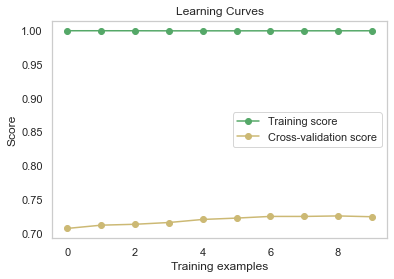

In [35]:
draw_learning_curves(X_train, y_train, RandomForestClassifier(random_state=42), 10)

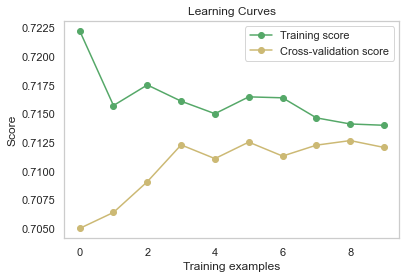

In [36]:
draw_learning_curves(X_train, y_train, AdaBoostClassifier(random_state=42), 10)

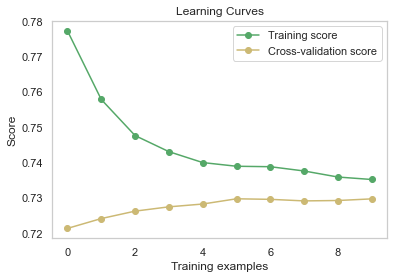

In [37]:
draw_learning_curves(X_train, y_train, GradientBoostingClassifier(), 10)

RandomForest seems to overfit, since there train score is very high and the cross-validation score does not increase so much. AdaBoost and GradientBoost seems to work very well, but GradientBoost has a slightly higher score so I'll choose gradientBoost as the classifier for building my model.

In [38]:
gradientBoost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [39]:
param_grid = {
    "max_depth" : [3,4,5],
    "n_estimators": [50,100]
}

# run grid search
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),
    param_grid=param_grid, 
    scoring = 'f1_weighted',
    verbose=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......max_depth=3, n_estimators=50;, score=0.713 total time=   5.6s
[CV 2/5] END ......max_depth=3, n_estimators=50;, score=0.715 total time=  10.1s
[CV 3/5] END ......max_depth=3, n_estimators=50;, score=0.705 total time=   5.6s
[CV 4/5] END ......max_depth=3, n_estimators=50;, score=0.720 total time=   5.5s
[CV 5/5] END ......max_depth=3, n_estimators=50;, score=0.708 total time=   5.3s
[CV 1/5] END .....max_depth=3, n_estimators=100;, score=0.721 total time=  10.7s
[CV 2/5] END .....max_depth=3, n_estimators=100;, score=0.721 total time=   9.8s
[CV 3/5] END .....max_depth=3, n_estimators=100;, score=0.711 total time=   9.9s
[CV 4/5] END .....max_depth=3, n_estimators=100;, score=0.724 total time=  10.6s
[CV 5/5] END .....max_depth=3, n_estimators=100;, score=0.715 total time=   9.8s
[CV 1/5] END ......max_depth=4, n_estimators=50;, score=0.720 total time=   6.4s
[CV 2/5] END ......max_depth=4, n_estimators=50;,

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'max_depth': [3, 4, 5], 'n_estimators': [50, 100]},
             scoring='f1_weighted', verbose=5)

In [40]:
grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

(GradientBoostingClassifier(max_depth=5, random_state=42),
 {'max_depth': 5, 'n_estimators': 100},
 0.7220939548687156)

#### Model comparison

I tried 3 different classifier and tuned the best fitting of them using GridSearch. The table show my choosen models and their scores.

In [41]:
def printMetrics(models):
    '''
    Print table for metrics of the given models.
    
    INPUT
    models - dictionary that contains model name as key and the model itself as value
    '''
    metrics_df = pd.DataFrame(columns=['model', 'accuracy_score', 'f1-score'])
    for name, model in models.items():
        y_pred = model.predict(X_test)
        metrics_df = metrics_df.append({'model': name,
                           'accuracy_score': accuracy_score(y_test, y_pred),
                           'f1-score': f1_score(y_test, y_pred, average='weighted')
                          }, ignore_index=True)
    return metrics_df
        

In [42]:
printMetrics({'randomForest':randomForest, 'adaBoost':adaBoost, 'gradientBoost':gradientBoost, 'bestGradientBoost': grid_search})

,model,accuracy_score,f1-score
0,randomForest,0.729490,0.722865
1,adaBoost,0.706241,0.686025
2,gradientBoost,0.731659,0.721353
3,bestGradientBoost,0.734604,0.725515


I was able to optimize the gradientBoost classifier a little bit even it is not mind-blowing.

## Conclusion

#### Reflexion

I started with 3 datasets given by Starbucks, the first was containing the portfolio, that describes to attributes of specific offers Starbucks sends to their customers. The second dataset contains attributes for each user and the third one contains events or interactions between the customers and the Starbucks App. 

Given that I was questions myself if I can find relations between customers, the offers offered to them and the interaction the customers take with their offers. Or more specific "Will a 42 years old woman with an income of 75000 a received offer view or even complete?"

I was contentration on the third dataset with all the transscriptions. I extracted three datasets that contained the received, viewed and completed events. Since I'm a developer I had could written a function, that computes the interaction between a customer and the given offer, but a quick check (iteration over a dataset and check if it exist in another datasert) told me, that this step would take to much time. So I deceided to merge my dataframes, compute the duration, and remove unlogical (viewed before received) and duplicated (because of the merge) rows. This worked pretty well, but I missed some events and it took me quite a lot of time, to understand whats happen to them. Fortunately I found an explanation, that I described above. They were the last received once, which where not viewed.

from taht point it was easy to merge the attributes from the profiles, get rid of the person id columns, remove the rows with missing data (that were just persons with missing attributes) and dummy the offer_id and gender columns to prepare the dataframe for the machine learning part.

My question is a classification problem, so I started with the RandomForest classifier, which I thought that would be a good choice. I found interesting that this classifier seems to overfit on my data. The train score was at 1.0 while the test score could not get better than 0.72. Then I tried AdaBoost classifier which was score was a bit worst than RandomForest, but at leats it doesn't seem to overfit. So I tried another classifier GradientBoost, that fits very well and had ven the best scores of the three. SO this was a lucky punch, because I had never really used GradientBoost before, it was not even on my mind.

I tried to tune my chosen classifier a bit, but that does not really improve the performance. An accuracy score of 0.735 and an f1-score of 0.726 is may be not outstanding, but when I look at the data, then this is a good result. Since a person will not end up with the same status for a given offer, the metrics of the model can not be perfect. A person A which gets an offer B several times, the person will not always complete or view this offer.

#### Improvements

Here are some thoughts about how this project can be improved.

**1. Find the missing events**
    
During the merge of the offer datasets I lost some events and tried to explain the reason therefore. It would be better to work with all these events, so go, find and add them to the offers.
    
**2. Take care of the transactions**
    
In the transcript dataset the is an event type transcriptions. Combine this data with the offers dataframe. How many transactions did a customer in each timeframe between the offer received? How much money does a customer spent during such a timeframe?
    

## The App

The repository of this project contains an App. There is a README.md file where you can find the instructions how to run this app.

When I wrote the app I had to change my model a little bit. I decided to drop the columns 'time' and 'became_member_on', because it makes it easier to play around with the three given values 'gender', 'age' and 'income'. I also set up initial values for the three parameter. Feel free to change theses values and checked what my model suggests. Start with the gender and see what's happen.